<a href="https://colab.research.google.com/github/alinjomaa/C.Elegan_segmentation_ML_models/blob/main/finetuned_sam3_C_elegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-Tuned SAM 3 Model for Worm Segmentation via Point Prompts

In this notebook, I fine-tuned Meta's SAM 3 model on a custom dataset of *C. elegans* worms. When comparing inference results between the Detectron2 Mask R-CNN model and SAM 3, I found that SAM 3 achieved significantly greater accuracy in segmenting touching and overlapping worms. The primary limitation of using SAM 3 is its requirement for prompting.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Install dependencies
!pip install torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

# Clone and install SAM3
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e .

# Install Hugging Face hub for model download
!pip install huggingface_hub

Looking in indexes: https://download.pytorch.org/whl/cu126
fatal: destination path 'sam3' already exists and is not an empty directory.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15365 sha256=9f58f727f2bc9225644cbb81ae889dd7fe349c11eaad2dddc28da0a56e6a5aa3
  Stored in directory: /tmp/pip-ephem-wheel-cache-3o2csdn0/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


In [2]:
from huggingface_hub import login
login()

In [3]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 137.1 MB/s eta 0:00:00


In [4]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, ConcatDataset
from pycocotools import mask as mask_utils


class WormDataset(Dataset):
    """A PyTorch Dataset for loading worm segmentation data in COCO format."""
    def __init__(self, coco_annotations_path, image_directory):
        """
        Initializes the dataset with COCO annotations and image directory.

        Args:
            coco_annotations_path (str): Path to the COCO JSON annotation file.
            image_directory (str): Path to the directory containing images.
        """
        with open(coco_annotations_path, "r") as f:
            coco_dataset_data = json.load(f)

        self.image_directory = image_directory
        self.image_information = coco_dataset_data["images"]
        self.segmentation_annotations = coco_dataset_data["annotations"]

        self.image_id_to_annotations_map = {}
        for annotation_entry in self.segmentation_annotations:
            image_identifier = annotation_entry["image_id"]
            if image_identifier not in self.image_id_to_annotations_map:
                self.image_id_to_annotations_map[image_identifier] = []
            self.image_id_to_annotations_map[image_identifier].append(annotation_entry)

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.image_information)

    def _ann_to_mask(self, annotation_entry, height, width):
        """Converts a COCO annotation entry into a binary segmentation mask."""
        segmentation_info = annotation_entry.get("segmentation", None)
        if segmentation_info is None:
            return None

        if isinstance(segmentation_info, list):
            if len(segmentation_info) > 0 and isinstance(segmentation_info[0], (int, float)):
                segmentation_info = [segmentation_info]

            run_length_encodings = mask_utils.frPyObjects(segmentation_info, height, width)


            if isinstance(run_length_encodings, dict):
                run_length_encoding = run_length_encodings
            else:
                run_length_encoding = mask_utils.merge(run_length_encodings)

            segmentation_mask = mask_utils.decode(run_length_encoding)
            return segmentation_mask


        if isinstance(segmentation_info, dict):
            run_length_encoding = segmentation_info


            if isinstance(run_length_encoding.get("counts", None), list):
                run_length_encoding = mask_utils.frPyObjects(run_length_encoding, height, width)

            segmentation_mask = mask_utils.decode(run_length_encoding)
            return segmentation_mask

        return None

    def __getitem__(self, idx):
        """Retrieves an image, its segmentation masks, and corresponding center points by index."""
        image_metadata = self.image_information[idx]
        image_path = os.path.join(self.image_directory, image_metadata["file_name"])
        input_image = Image.open(image_path).convert("RGB")

        height = image_metadata.get("height", input_image.height)
        width = image_metadata.get("width", input_image.width)

        annotations_for_image = self.image_id_to_annotations_map.get(image_metadata["id"], [])

        segmentation_masks = []
        center_points = []

        for annotation_entry in annotations_for_image:
            segmentation_mask = self._ann_to_mask(annotation_entry, height, width)
            if segmentation_mask is None:
                continue


            if segmentation_mask.ndim == 3:
                segmentation_mask = segmentation_mask[:, :, 0]

            if segmentation_mask.sum() == 0:
                continue

            segmentation_masks.append(segmentation_mask.astype(np.uint8))

            y_coords, x_coords = np.where(segmentation_mask > 0)
            center_x = int(x_coords.mean())
            center_y = int(y_coords.mean())
            center_points.append([center_x, center_y])

        if len(segmentation_masks) == 0:
            segmentation_masks = np.zeros((1, height, width), dtype=np.uint8)
            center_points = []

        segmentation_masks = torch.from_numpy(np.stack(segmentation_masks)).float()

        if len(center_points) == 0:
            center_points = torch.zeros((0, 2), dtype=torch.float32)
        else:
            center_points = torch.tensor(center_points, dtype=torch.float32)

        return {
            "image": input_image,
            "masks": segmentation_masks,
            "points": center_points
        }


worm_dataset_1 = WormDataset(
    "/content/drive/MyDrive/worm_segmentation/annotations_cleaned.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train"
)

worm_dataset_2 = WormDataset(
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/images"
)

worm_dataset_3 = WormDataset(
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2_annotations/_annotations.coco.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2"
)

train_dataset = ConcatDataset([worm_dataset_1, worm_dataset_2, worm_dataset_3])

print("Total training images:", len(train_dataset))
print("  - Dataset 1:", len(worm_dataset_1), "images")
print("  - Dataset 2:", len(worm_dataset_2), "images")
print("  - Dataset 3:", len(worm_dataset_3), "images")

Total training images: 1626
  - Dataset 1: 197 images
  - Dataset 2: 1000 images
  - Dataset 3: 429 images


In [ ]:
import os
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import Sam3TrackerModel, Sam3TrackerProcessor


def custom_collate(data_batch):
    """Custom collate function for the DataLoader to handle variable-sized masks/points."""
    return {
        "image": [batch_item["image"] for batch_item in data_batch],
        "masks": [batch_item["masks"] for batch_item in data_batch],
        "points": [batch_item["points"] for batch_item in data_batch],
    }


def dice_loss_with_logits(predicted_logits, ground_truth_targets, eps=1e-6):
    """Calculates the Dice loss between predicted logits and ground truth targets."""
    predicted_probabilities = torch.sigmoid(predicted_logits)
    predicted_probabilities = predicted_probabilities.reshape(predicted_probabilities.shape[0], -1)
    ground_truth_targets = ground_truth_targets.reshape(ground_truth_targets.shape[0], -1)
    intersection = (predicted_probabilities * ground_truth_targets).sum(dim=1)
    denominator = predicted_probabilities.sum(dim=1) + ground_truth_targets.sum(dim=1)
    dice_coefficient = (2 * intersection + eps) / (denominator + eps)
    return (1 - dice_coefficient).mean()


def mean_iou_from_logits(predicted_logits, ground_truth_targets, thr=0.5, eps=1e-6):
    """Calculates the mean IoU (Intersection over Union) from predicted logits and ground truth."""
    predictions_binary = (torch.sigmoid(predicted_logits) > thr).float()
    predictions_binary = predictions_binary.reshape(predictions_binary.shape[0], -1)
    ground_truth_targets = ground_truth_targets.reshape(ground_truth_targets.shape[0], -1)
    intersection = (predictions_binary * ground_truth_targets).sum(dim=1)
    union = predictions_binary.sum(dim=1) + ground_truth_targets.sum(dim=1) - intersection
    iou_score = (intersection + eps) / (union + eps)
    return iou_score.mean().item()


def choose_one_instance(all_masks, all_points):
    """Randomly selects one instance (mask and corresponding point) from a batch."""
    if all_masks.ndim == 2:
        all_masks = all_masks.unsqueeze(0)

    num_instances = all_masks.shape[0]
    if num_instances == 0:
        return None, None

    random_index = random.randint(0, num_instances - 1)

    if torch.is_tensor(all_points) and all_points.ndim == 2 and all_points.shape[0] == num_instances:
        return all_masks[random_index].unsqueeze(0), all_points[random_index].unsqueeze(0)

    return all_masks[random_index].unsqueeze(0), None


def point_from_single_mask(input_single_mask):
    """Computes the center point of a single segmentation mask."""
    if input_single_mask.ndim == 3:
        processed_mask = input_single_mask[0]
    else:
        processed_mask = input_single_mask

    y_coords, x_coords = torch.where(processed_mask > 0.5)
    if y_coords.numel() > 0:
        center_y = int(torch.mean(y_coords.float()).item())
        center_x = int(torch.mean(x_coords.float()).item())
        return torch.tensor([[center_x, center_y]], dtype=torch.float32)

    mask_height = processed_mask.shape[-2]
    mask_width = processed_mask.shape[-1]
    return torch.tensor([[mask_width // 2, mask_height // 2]], dtype=torch.float32)


def get_pred_logits(model_outputs):
    """Extracts and preprocesses predicted mask logits from model outputs."""
    raw_predicted_logits = model_outputs.pred_masks

    # Remove singleton dimensions more carefully
    while raw_predicted_logits.ndim > 3:
        if raw_predicted_logits.shape[0] == 1:
            raw_predicted_logits = raw_predicted_logits.squeeze(0)
        else:
            raw_predicted_logits = raw_predicted_logits[0]
            break

    if raw_predicted_logits.ndim == 3:
        raw_predicted_logits = raw_predicted_logits[0].unsqueeze(0)

    if raw_predicted_logits.ndim == 2:
        raw_predicted_logits = raw_predicted_logits.unsqueeze(0)

    return raw_predicted_logits


def align_gt_to_pred(predicted_logits, ground_truth_mask):
    """Resizes the ground truth mask to match the dimensions of the predicted logits."""
    if ground_truth_mask.ndim == 2:
        ground_truth_mask = ground_truth_mask.unsqueeze(0)
    ground_truth_mask = ground_truth_mask.float()

    if predicted_logits.shape[-2:] != ground_truth_mask.shape[-2:]:
        ground_truth_mask = F.interpolate(
            ground_truth_mask.unsqueeze(1),
            size=predicted_logits.shape[-2:],
            mode="bilinear",
            align_corners=False
        ).squeeze(1)

    if predicted_logits.shape != ground_truth_mask.shape:
        raise ValueError("Shape mismatch pred " + str(tuple(predicted_logits.shape)) + " vs gt " + str(tuple(ground_truth_mask.shape)))

    return ground_truth_mask


def train_sam3(
    training_dataset,
    number_of_epochs=20,
    training_batch_size=1,
    learning_rate=1e-4,
    optimizer_weight_decay=0.01,
    gradient_accumulation_steps=4,
    use_automatic_mixed_precision=True,
    checkpoint_save_directory="/content/drive/MyDrive/sam3_worm_checkpoints",
    save_checkpoint_every_steps=500
):
    """Trains the SAM3 model for worm segmentation using point prompts."""
    os.makedirs(checkpoint_save_directory, exist_ok=True)

    computation_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    is_cuda_available = (computation_device.type == "cuda")

    sam3_model = Sam3TrackerModel.from_pretrained("facebook/sam3")
    sam3_processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

    for param_name, parameter in sam3_model.named_parameters():
        if "vision_encoder" in param_name or "image_encoder" in param_name:
            parameter.requires_grad = False
        else:
            parameter.requires_grad = True

    trainable_parameters = [p for p in sam3_model.parameters() if p.requires_grad]
    if len(trainable_parameters) == 0:
        for p in sam3_model.parameters():
            p.requires_grad = True
        trainable_parameters = list(sam3_model.parameters())

    sam3_model.to(computation_device)
    sam3_model.train()

    model_optimizer = torch.optim.AdamW(trainable_parameters, lr=learning_rate, weight_decay=optimizer_weight_decay)
    gradient_scaler = torch.cuda.amp.GradScaler(enabled=(use_automatic_mixed_precision and is_cuda_available))

    training_data_loader = DataLoader(
        training_dataset,
        batch_size=training_batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )

    total_training_steps = 0
    current_accumulation_steps = 0

    for current_epoch in range(number_of_epochs):
        total_epoch_loss = 0.0
        total_epoch_iou = 0.0

        total_examples_processed = 0
        successful_examples = 0
        auto_generated_points_count = 0
        failed_examples = 0
        skipped_examples = 0

        model_optimizer.zero_grad(set_to_none=True)

        progress_bar = tqdm(training_data_loader, desc="Epoch " + str(current_epoch + 1) + "/" + str(number_of_epochs))

        for data_batch in progress_bar:
            for batch_index in range(len(data_batch["image"])):
                total_examples_processed += 1

                input_image = data_batch["image"][batch_index]
                ground_truth_masks = data_batch["masks"][batch_index].to(computation_device)
                ground_truth_points = data_batch["points"][batch_index]

                try:
                    selected_ground_truth_mask, selected_point_prompt = choose_one_instance(ground_truth_masks, ground_truth_points)
                    if selected_ground_truth_mask is None:
                        skipped_examples += 1
                        continue

                    if selected_point_prompt is None or (torch.is_tensor(selected_point_prompt) and selected_point_prompt.numel() == 0):
                        selected_point_prompt = point_from_single_mask(selected_ground_truth_mask.detach())
                        auto_generated_points_count += 1

                    if not torch.is_tensor(selected_point_prompt):
                        selected_point_prompt = torch.tensor(selected_point_prompt, dtype=torch.float32)

                    processor_input_points = [[selected_point_prompt.detach().cpu().tolist()]]
                    processor_input_labels = [[[1] * selected_point_prompt.shape[0]]]

                    processed_inputs = sam3_processor(
                        images=input_image,
                        input_points=processor_input_points,
                        input_labels=processor_input_labels,
                        return_tensors="pt"
                    )
                    processed_inputs = processed_inputs.to(computation_device)

                    if use_automatic_mixed_precision and is_cuda_available:
                        with torch.cuda.amp.autocast():
                            model_outputs = sam3_model(**processed_inputs, multimask_output=False)
                            predicted_mask_logits = get_pred_logits(model_outputs)
                            aligned_ground_truth_mask = align_gt_to_pred(predicted_mask_logits, selected_ground_truth_mask)
                            current_loss = F.binary_cross_entropy_with_logits(predicted_mask_logits, aligned_ground_truth_mask) + dice_loss_with_logits(predicted_mask_logits, aligned_ground_truth_mask)
                            current_loss = current_loss / gradient_accumulation_steps
                    else:
                        model_outputs = sam3_model(**processed_inputs, multimask_output=False)
                        predicted_mask_logits = get_pred_logits(model_outputs)
                        aligned_ground_truth_mask = align_gt_to_pred(predicted_mask_logits, selected_ground_truth_mask)
                        current_loss = F.binary_cross_entropy_with_logits(predicted_mask_logits, aligned_ground_truth_mask) + dice_loss_with_logits(predicted_mask_logits, aligned_ground_truth_mask)
                        current_loss = current_loss / gradient_accumulation_steps

                    if gradient_scaler.is_enabled():
                        gradient_scaler.scale(current_loss).backward()
                    else:
                        current_loss.backward()

                    current_accumulation_steps += 1


                    if current_accumulation_steps >= gradient_accumulation_steps:
                        if gradient_scaler.is_enabled():
                            gradient_scaler.unscale_(model_optimizer)

                        torch.nn.utils.clip_grad_norm_(trainable_parameters, 1.0)

                        if gradient_scaler.is_enabled():
                            gradient_scaler.step(model_optimizer)
                            gradient_scaler.update()
                        else:
                            model_optimizer.step()

                        model_optimizer.zero_grad(set_to_none=True)
                        current_accumulation_steps = 0

                    successful_examples += 1
                    total_training_steps += 1

                    total_epoch_loss += current_loss.item() * gradient_accumulation_steps
                    total_epoch_iou += mean_iou_from_logits(predicted_mask_logits.detach(), aligned_ground_truth_mask.detach())

                    average_epoch_loss = total_epoch_loss / max(1, successful_examples)
                    average_epoch_iou = total_epoch_iou / max(1, successful_examples)

                    progress_bar.set_postfix({
                        "Loss": f"{(current_loss.item() * gradient_accumulation_steps):.4f}",
                        "Avg": f"{average_epoch_loss:.4f}",
                        "IoU": f"{average_epoch_iou:.3f}",
                        "Success": str(successful_examples) + "/" + str(total_examples_processed),
                        "AutoPts": auto_generated_points_count,
                        "Skip": skipped_examples,
                        "Fail": failed_examples
                    })

                    if save_checkpoint_every_steps and total_training_steps % save_checkpoint_every_steps == 0:
                        checkpoint_path = os.path.join(checkpoint_save_directory, "step_" + str(total_training_steps))
                        os.makedirs(checkpoint_path, exist_ok=True)
                        sam3_model.save_pretrained(checkpoint_path)

                except Exception as e:
                    failed_examples += 1
                    if failed_examples <= 5:
                        print("\nFAILED example:", str(e))
                        try:
                            print("masks shape:", tuple(ground_truth_masks.shape))
                        except:
                            pass
                    continue


        if current_accumulation_steps > 0:
            if gradient_scaler.is_enabled():
                gradient_scaler.unscale_(model_optimizer)

            torch.nn.utils.clip_grad_norm_(trainable_parameters, 1.0)

            if gradient_scaler.is_enabled():
                gradient_scaler.step(model_optimizer)
                gradient_scaler.update()
            else:
                model_optimizer.step()

            model_optimizer.zero_grad(set_to_none=True)
            current_accumulation_steps = 0

        print("\nEpoch", current_epoch + 1, "done")
        print("Avg loss:", total_epoch_loss / max(1, successful_examples))
        print("Avg IoU :", total_epoch_iou / max(1, successful_examples))
        print("Success:", str(successful_examples) + "/" + str(total_examples_processed))
        print("Auto points:", auto_generated_points_count, "| Skipped:", skipped_examples, "| Failed:", failed_examples)


train_sam3(train_dataset, number_of_epochs=20, training_batch_size=1, gradient_accumulation_steps=4, use_automatic_mixed_precision=True)

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

You are using a model of type sam3_video to instantiate a model of type sam3_tracker. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/685 [00:00<?, ?it/s]

processor_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

/tmp/ipython-input-2648395357.py:153: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  gradient_scaler = torch.cuda.amp.GradScaler(enabled=(use_automatic_mixed_precision and is_cuda_available))
Epoch 1/20:   0%|          | 0/1626 [00:00<?, ?it/s]/tmp/ipython-input-2648395357.py:213: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20:   2%|▏         | 36/1626 [00:29<21:46,  1.22it/s, Loss=0.7439, Avg=0.5077, IoU=0.472, Success=36/36, AutoPts=0, Skip=0, Fail=0]


KeyboardInterrupt: 

In [5]:
import base64
from io import BytesIO
from PIL import Image

OBJECTS = ['worm']

def encode_image_pillow(image: Image.Image) -> str:
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    image_bytes = buffer.getvalue()
    encoded = base64.b64encode(image_bytes).decode("utf-8")
    return "data:image/jpeg;base64," + encoded

In [6]:
import numpy as np

def get_normalized_boxes(bboxes, label, resolution_wh):
    width, height = resolution_wh
    boxes = [
        [b["x"] + b["width"] / 2, b["y"] + b["height"] / 2, b["width"], b["height"]]
        for b in bboxes
        if b["label"] == label
    ]
    if not boxes:
        return np.empty((0, 4), dtype=np.float32)
    scale = np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
    return np.array(boxes, dtype=np.float32) / scale

In [7]:
!pip install jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [10]:
from PIL import Image
from jupyter_bbox_widget import BBoxWidget


image_path = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/val/Imaging_fmo-2MC_DR_smell2_ch01.jpg"
image = Image.open(image_path).convert("RGB")

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image_pillow(image)
widget

Loading weights:   0%|          | 0/685 [00:00<?, ?it/s]

Derived 14 points from bounding boxes. Performing inference...


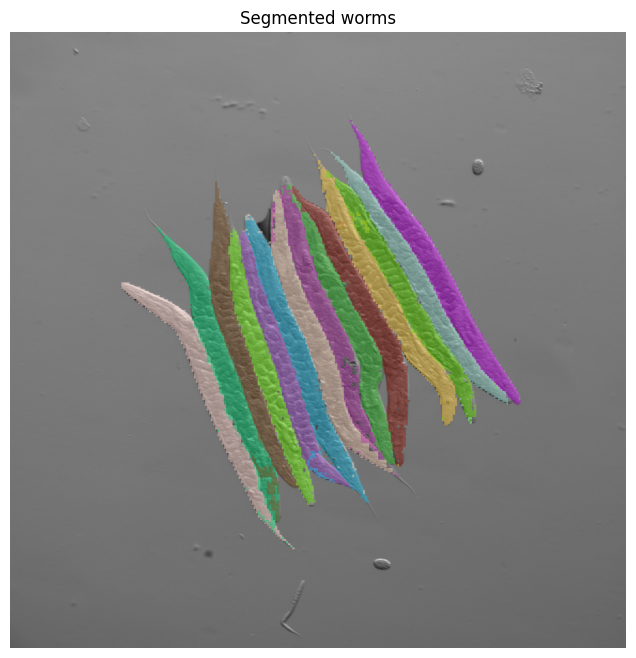

Successfully segmented 14 objects.
Saved masks to: /content/worm_segmentation_masks.npy with shape (14, 1024, 1024)


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import Sam3TrackerModel, Sam3TrackerProcessor
import shutil
import os
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

model_save_dir = "/content/drive/MyDrive/sam3_worm_checkpoints"
model_checkpoint_name = "step_22500"

model_path_on_drive = os.path.join(model_save_dir, model_checkpoint_name)
local_model_path = os.path.join("/content", model_checkpoint_name)

if not os.path.exists(local_model_path):
    print(f"Copying model from drive: {model_path_on_drive} to {local_model_path}")
    try:
        shutil.copytree(model_path_on_drive, local_model_path)
        print("Model copied successfully.")
    except Exception as e:
        print(f"Error copying model: {e}")
        print("Please ensure the model path exists and is accessible.")
        raise

needed_files = ["config.json", "model.safetensors"]
missing_files = []
for filename in needed_files:
    full_path = os.path.join(local_model_path, filename)
    if not os.path.exists(full_path):
        missing_files.append(filename)

if missing_files:
    raise FileNotFoundError(f"Missing in {local_model_path}: {missing_files}")

model = Sam3TrackerModel.from_pretrained(local_model_path).to(device)
model.eval()

try:
    processor = Sam3TrackerProcessor.from_pretrained(local_model_path)
except Exception:
    processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

bbox_annotations = widget.bboxes

input_points_for_processor = []
input_labels_for_processor = []

if bbox_annotations:
    current_image_points = []
    current_image_labels = []

    for bbox_info in bbox_annotations:
        x_min = bbox_info["x"]
        y_min = bbox_info["y"]
        width = bbox_info["width"]
        height = bbox_info["height"]

        center_x = x_min + (width / 2)
        center_y = y_min + (height / 2)

        current_image_points.append([[center_x, center_y]])
        current_image_labels.append([1])

    input_points_for_processor.append(current_image_points)
    input_labels_for_processor.append(current_image_labels)

if (not input_points_for_processor) or (len(input_points_for_processor[0]) == 0):
    print("No points derived from bounding boxes for segmentation.")
else:
    num_derived_points = len(input_points_for_processor[0])
    print(f"Derived {num_derived_points} points from bounding boxes. Performing inference...")

    overlay = np.array(image).astype(np.float32)
    all_masks = []

    inputs = processor(
        images=image,
        input_points=input_points_for_processor,
        input_labels=input_labels_for_processor,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    pred_masks = outputs.pred_masks

    if pred_masks.ndim == 5:
        pred_masks = pred_masks[:, :, 0, :, :]

    if pred_masks.ndim != 4:
        raise ValueError(f"Unexpected pred_masks shape: {tuple(outputs.pred_masks.shape)}")

    num_objects = pred_masks.shape[1]

    for i in range(num_objects):
        mask_logit = pred_masks[0, i, :, :]

        mask = (torch.sigmoid(mask_logit) > 0.3).cpu().numpy().astype(np.uint8)

        mask_pil = Image.fromarray(mask)
        mask_resized = mask_pil.resize((image.width, image.height), Image.NEAREST)
        mask = np.array(mask_resized)

        all_masks.append(mask)

        color = np.random.uniform(0, 255, size=(3,))
        alpha = 0.5

        overlay[mask == 1] = overlay[mask == 1] * (1 - alpha) + color * alpha

    plt.figure(figsize=(10, 8))
    plt.imshow(overlay.astype(np.uint8))
    plt.axis("off")
    plt.title("Segmented worms")
    plt.show()

    masks_array = np.stack(all_masks, axis=0)
    output_filename = "/content/worm_segmentation_masks.npy"
    np.save(output_filename, masks_array)

    print(f"Successfully segmented {len(all_masks)} objects.")
    print(f"Saved masks to: {output_filename} with shape {masks_array.shape}")

## old training script

In [ ]:
import os
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import Sam3TrackerModel, Sam3TrackerProcessor


def custom_collate(batch):
    return {
        "image": [item["image"] for item in batch],
        "masks": [item["masks"] for item in batch],
        "points": [item["points"] for item in batch],
    }


def dice_loss_with_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    probs = probs.reshape(probs.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)
    inter = (probs * targets).sum(dim=1)
    denom = probs.sum(dim=1) + targets.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()


def mean_iou_from_logits(logits, targets, thr=0.5, eps=1e-6):
    preds = (torch.sigmoid(logits) > thr).float()
    preds = preds.reshape(preds.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)
    inter = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()


def choose_one_instance(masks, points):
    if masks.ndim == 2:
        masks = masks.unsqueeze(0)

    n = masks.shape[0]
    if n == 0:
        return None, None

    k = random.randint(0, n - 1)

    if torch.is_tensor(points) and points.ndim == 2 and points.shape[0] == n:
        return masks[k].unsqueeze(0), points[k].unsqueeze(0)

    return masks[k].unsqueeze(0), None


def point_from_single_mask(single_mask):
    if single_mask.ndim == 3:
        m = single_mask[0]
    else:
        m = single_mask

    ys, xs = torch.where(m > 0.5)
    if ys.numel() > 0:
        y = int(torch.mean(ys.float()).item())
        x = int(torch.mean(xs.float()).item())
        return torch.tensor([[x, y]], dtype=torch.float32)

    h = m.shape[-2]
    w = m.shape[-1]
    return torch.tensor([[w // 2, h // 2]], dtype=torch.float32)


def get_pred_logits(outputs):
    pred = outputs.pred_masks
    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)
    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)
    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)

    while pred.ndim > 3 and pred.shape[0] == 1:
        pred = pred.squeeze(0)

    while pred.ndim > 3:
        if pred.shape[0] == 1:
            pred = pred.squeeze(0)
        else:
            pred = pred[0]

    if pred.ndim == 3:
        pred = pred[0].unsqueeze(0)

    if pred.ndim == 2:
        pred = pred.unsqueeze(0)

    return pred



def align_gt_to_pred(pred_logits, gt_mask):
    if gt_mask.ndim == 2:
        gt_mask = gt_mask.unsqueeze(0)
    gt_mask = gt_mask.float()

    if pred_logits.shape[-2:] != gt_mask.shape[-2:]:
        gt_mask = F.interpolate(
            gt_mask.unsqueeze(1),
            size=pred_logits.shape[-2:],
            mode="bilinear",
            align_corners=False
        ).squeeze(1)

    if pred_logits.shape != gt_mask.shape:
        raise ValueError("Shape mismatch pred " + str(tuple(pred_logits.shape)) + " vs gt " + str(tuple(gt_mask.shape)))

    return gt_mask


def train_sam3(
    train_dataset,
    num_epochs=20,
    batch_size=1,
    lr=1e-4,
    weight_decay=0.01,
    grad_accum=4,
    use_amp=True,
    save_dir="/content/drive/MyDrive/sam3_worm_checkpoints",
    save_every_steps=500
):
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_cuda = (device.type == "cuda")

    model = Sam3TrackerModel.from_pretrained("facebook/sam3")
    processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

    for name, p in model.named_parameters():
        if "vision_encoder" in name or "image_encoder" in name:
            p.requires_grad = False
        else:
            p.requires_grad = True

    trainable = [p for p in model.parameters() if p.requires_grad]
    if len(trainable) == 0:
        for p in model.parameters():
            p.requires_grad = True
        trainable = list(model.parameters())

    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(trainable, lr=lr, weight_decay=weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and use_cuda))

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )

    global_step = 0

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_iou = 0.0

        seen = 0
        success = 0
        auto_points = 0
        failed = 0
        skipped = 0

        optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(train_loader, desc="Epoch " + str(epoch + 1) + "/" + str(num_epochs))

        for batch in pbar:
            for bi in range(len(batch["image"])):
                seen += 1

                image = batch["image"][bi]
                masks = batch["masks"][bi].to(device)
                points = batch["points"][bi]

                try:
                    gt_mask, pt = choose_one_instance(masks, points)
                    if gt_mask is None:
                        skipped += 1
                        continue

                    if pt is None or (torch.is_tensor(pt) and pt.numel() == 0):
                        pt = point_from_single_mask(gt_mask.detach())
                        auto_points += 1

                    if not torch.is_tensor(pt):
                        pt = torch.tensor(pt, dtype=torch.float32)

                    input_points = [[pt.detach().cpu().tolist()]]
                    input_labels = [[[1] * pt.shape[0]]]

                    inputs = processor(
                        images=image,
                        input_points=input_points,
                        input_labels=input_labels,
                        return_tensors="pt"
                    )
                    inputs = inputs.to(device)

                    if use_amp and use_cuda:
                        with torch.cuda.amp.autocast():
                            outputs = model(**inputs, multimask_output=False)
                            pred_logits = get_pred_logits(outputs)
                            gt_aligned = align_gt_to_pred(pred_logits, gt_mask)
                            loss = F.binary_cross_entropy_with_logits(pred_logits, gt_aligned) + dice_loss_with_logits(pred_logits, gt_aligned)
                            loss = loss / grad_accum
                    else:
                        outputs = model(**inputs, multimask_output=False)
                        pred_logits = get_pred_logits(outputs)
                        gt_aligned = align_gt_to_pred(pred_logits, gt_mask)
                        loss = F.binary_cross_entropy_with_logits(pred_logits, gt_aligned) + dice_loss_with_logits(pred_logits, gt_aligned)
                        loss = loss / grad_accum

                    if scaler.is_enabled():
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()

                    if (global_step + 1) % grad_accum == 0:
                        if scaler.is_enabled():
                            scaler.unscale_(optimizer)

                        torch.nn.utils.clip_grad_norm_(trainable, 1.0)

                        if scaler.is_enabled():
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            optimizer.step()

                        optimizer.zero_grad(set_to_none=True)

                    success += 1
                    global_step += 1

                    epoch_loss += loss.item() * grad_accum
                    epoch_iou += mean_iou_from_logits(pred_logits.detach(), gt_aligned.detach())

                    avg_loss = epoch_loss / max(1, success)
                    avg_iou = epoch_iou / max(1, success)

                    pbar.set_postfix({
                        "Loss": f"{(loss.item() * grad_accum):.4f}",
                        "Avg": f"{avg_loss:.4f}",
                        "IoU": f"{avg_iou:.3f}",
                        "Success": str(success) + "/" + str(seen),
                        "AutoPts": auto_points,
                        "Skip": skipped,
                        "Fail": failed
                    })

                    if save_every_steps and global_step % save_every_steps == 0:
                        ckpt_path = os.path.join(save_dir, "step_" + str(global_step))
                        os.makedirs(ckpt_path, exist_ok=True)
                        model.save_pretrained(ckpt_path)

                except Exception as e:
                    failed += 1
                    if failed <= 5:
                        print("\nFAILED example:", str(e))
                        try:
                            print("masks shape:", tuple(masks.shape))
                        except:
                            pass
                    continue

        print("\nEpoch", epoch + 1, "done")
        print("Avg loss:", epoch_loss / max(1, success))
        print("Avg IoU :", epoch_iou / max(1, success))
        print("Success:", str(success) + "/" + str(seen))
        print("Auto points:", auto_points, "| Skipped:", skipped, "| Failed:", failed)


train_sam3(train_dataset, num_epochs=20, batch_size=1, grad_accum=4, use_amp=True)